# Modèles de ML sur les données issues des requêtes

In [1]:
# librairies 
#----------------------------------------------
#----- Calculs 
import pandas as pd
import numpy as np
from numpy import mean, std
import numpy.linalg as npl
import math 
from math import sqrt, log
import re #to find integers & floats in a string 
from collections import Counter #to count values in a dataframe or array
#----- Date
from datetime import date, timedelta, datetime #for the date
import datetime as dt
#----- Graphes
import matplotlib.pyplot as plt #to plot graphs
import matplotlib.patches as mpatches #to customize legend
import seaborn as sns #to plot graphs
import pylab 
#----- Machine Learning Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.stats as stats
import random
#----- Feature selection
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
#----- Machine Learning Modèles 
from sklearn.tree import DecisionTreeRegressor
#save model 
import pickle 

In [2]:
descriptive_analysis=True

In [3]:
tune_hyperparamters=True #les étapes de tuning sont longues, à mettre True si on veut les réeffectuer

In [4]:
PATH = '.' #modifier si besoin le chemin du fichier

model_folder=PATH+"//models_sav/"

### Récupération & mise en forme des datasets

In [5]:
# Lecture du fichier des données tests
#----------------------------------------------

# récupération du fichier contentant l'ensemble des données issues des requêtes
pricing_requests = pd.read_csv(PATH + '//pricing_requests_done.csv')

# récupération du fichier contenant les features des hotels
hotels = pd.read_csv('features_hotels.csv', index_col=['hotel_id', 'city'])

print("pricing_requests.shape: ",pricing_requests.shape)
pricing_requests.head()

pricing_requests.shape:  (276012, 9)


,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_number
0,105,144,102,amsterdam,39,austrian,1,6056,1.0
1,880,113,81,amsterdam,39,austrian,1,6056,1.0
2,588,172,108,amsterdam,39,austrian,1,6056,1.0
3,352,105,84,amsterdam,39,austrian,1,6056,1.0
4,925,103,83,amsterdam,39,austrian,1,6056,1.0


In [6]:
# Obtenir des features en plus correspondant aux features de l'hotel : on fait une jointure 
#----------------------------------------------
pricing_requests = pricing_requests.join(hotels, on=['hotel_id', 'city'])
pricing_requests.head()

,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_number,group,brand,parking,pool,children_policy
0,105,144,102,amsterdam,39,austrian,1,6056,1.0,Yin Yang,Ardisson,0,0,0
1,880,113,81,amsterdam,39,austrian,1,6056,1.0,Boss Western,Boss Western,0,0,0
2,588,172,108,amsterdam,39,austrian,1,6056,1.0,Independant,Independant,0,0,0
3,352,105,84,amsterdam,39,austrian,1,6056,1.0,Independant,Independant,1,0,0
4,925,103,83,amsterdam,39,austrian,1,6056,1.0,Boss Western,Boss Western,1,0,0


In [7]:
# Assigner le bon type aux variables
#----------------------------------------------
#--- Convert to integer: 
int_list = ["date","avatar_id","hotel_id","stock","request_number","price"] 
pricing_requests[int_list] = pricing_requests[int_list].astype(int) 
#--- Convert to categorical: 
pricing_requests["city"] = pd.Categorical(pricing_requests["city"],ordered=False)
pricing_requests["language"] = pd.Categorical(pricing_requests["language"],ordered=False)
pricing_requests["mobile"] = pd.Categorical(pricing_requests["mobile"],ordered=False)
pricing_requests["parking"] = pd.Categorical(pricing_requests["parking"],ordered=False)
pricing_requests["pool"] = pd.Categorical(pricing_requests["pool"],ordered=False)
pricing_requests["children_policy"] = pd.Categorical(pricing_requests["children_policy"],ordered=False)
pricing_requests["group"] = pd.Categorical(pricing_requests["group"],ordered=False)
pricing_requests["brand"] = pd.Categorical(pricing_requests["brand"],ordered=False)

In [8]:
# Vérification du type des variables
#----------------------------------------------
pricing_requests.dtypes

hotel_id              int64
price                 int64
stock                 int64
city               category
date                  int64
language           category
mobile             category
avatar_id             int64
request_number        int64
group              category
brand              category
parking            category
pool               category
children_policy    category
dtype: object

### Variables langues, city, brand

In [9]:
print("groupes d'hôtels:\n",np.unique(pricing_requests["group"]))
print()
print("brand des hôtels:\n",np.unique(pricing_requests["brand"]))

groupes d'hôtels:
 ['Accar Hotels' 'Boss Western' 'Chillton Worldwide' 'Independant'
 'Morriott International' 'Yin Yang']

brand des hôtels:
 ['8 Premium' 'Ardisson' 'Boss Western' 'Chill Garden Inn' 'Corlton'
 'CourtYord' 'Ibas' 'Independant' 'J.Halliday Inn' 'Marcure' 'Morriot'
 'Navatel' 'Quadrupletree' 'Royal Lotus' 'Safitel' 'Tripletree']


On remarque que "brand" est inclus dans "group". Pour une première analyse, une idée serait de ne garder que la variable "brand".

In [10]:
def plotBar(feature: str): 
    """
    Cette fonction trace le barplot d'une feature  càd le nombre de requêtes effectuées 
    pour chaque modalité de la feature passée en argument. 
    ---> input: 
    * feature (string): nom de la feature dont on veut tracer le barplot.
    """
    dfFeature = pricing_requests[feature].value_counts()
    
    fig, ax1 = plt.subplots(1,figsize=(15,5))
    fig.tight_layout(pad=7)

    ax1.bar(dfFeature.index, dfFeature.values,alpha=.5)

    ax1.set_title("Nombre de requêtes effectuées par " + feature ,pad=20)
    ax1.set_xlabel(feature)
    ax1.set_ylabel("Nombre de requêtes réalisées")
    ax1.set_xticks(np.arange(0,len(dfFeature)))
    ax1.set_xticklabels(dfFeature.index, rotation=90)

    #calcul en pourcentage de requêtes dans les différentes langues 
    perL = 100 * dfFeature.values/sum(dfFeature.values) 

    j=0
    for i, v in enumerate(dfFeature.values):   
        ax1.text(i, v+10, str("%1.1f" % perL[j]) + "%" , ha="center",color = 'slateblue', size = 10, rotation = 0)  
        j+=1

    ax1.spines[['top','right','bottom','left']].set_visible(False)
    plt.show()

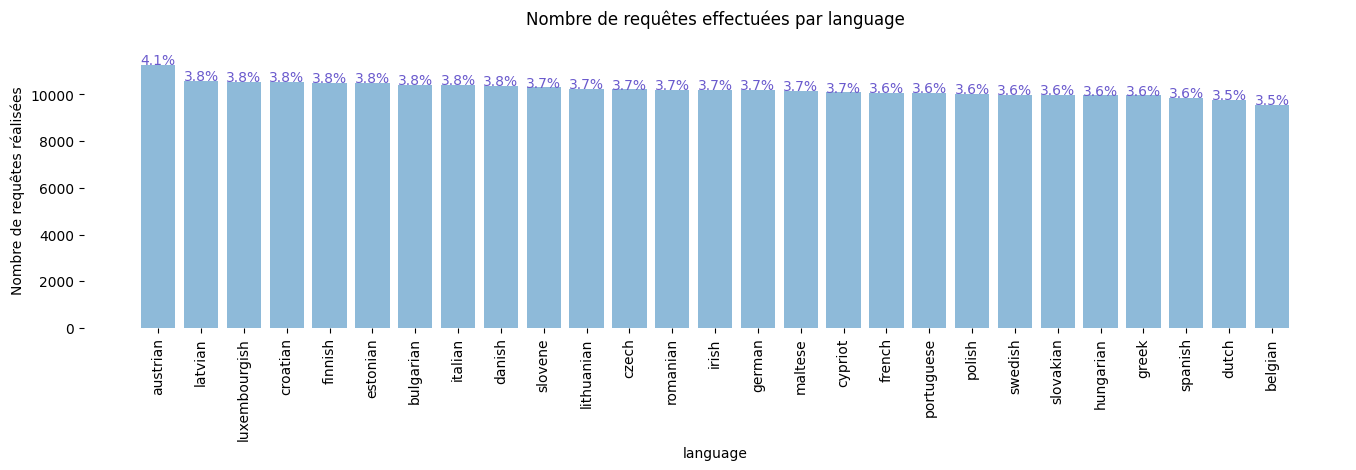

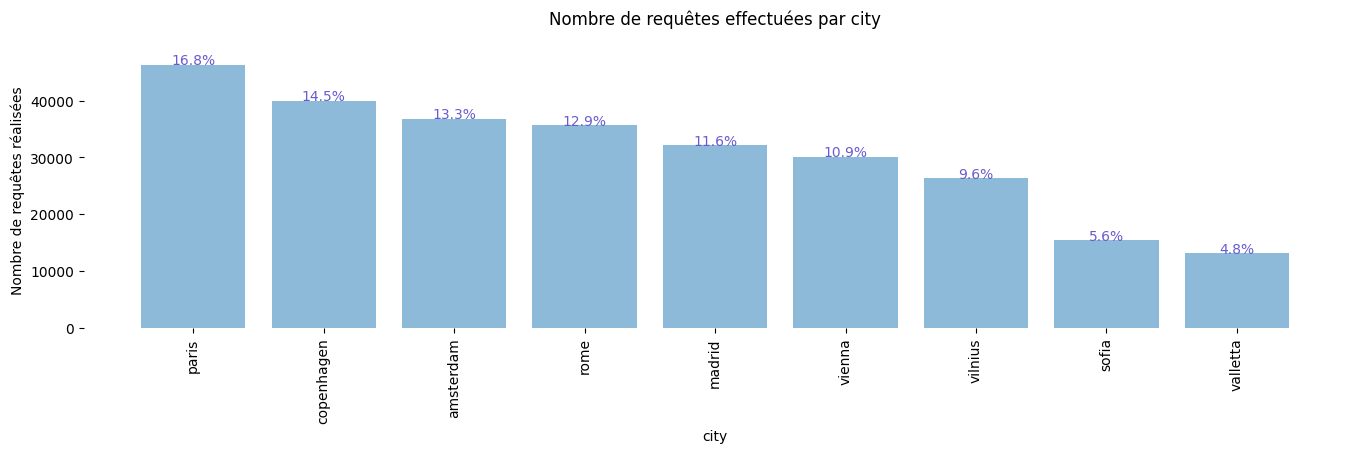

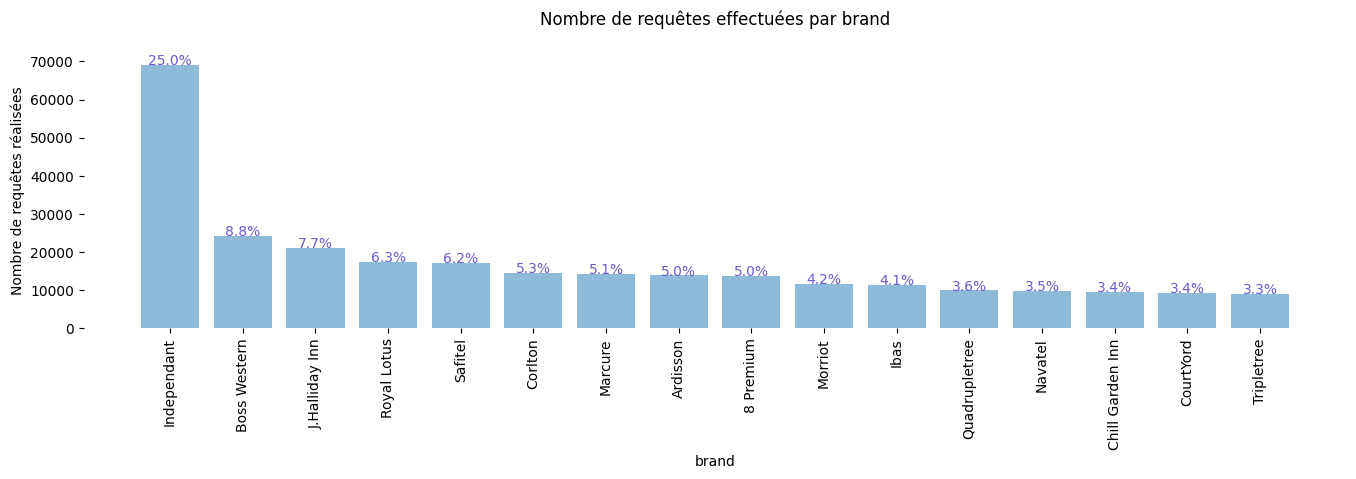

In [11]:
# Tracé des languesn villes et marques présentes dans le dataset
if descriptive_analysis: 
    plotBar('language')
    plotBar('city')
    plotBar('brand')

###  Variable price & stock

In [12]:
def plotHist(feature: str, start: int = 0, 
             stop: int = 500, step: int = 25, 
             bin_width: float = 4, qqPlot: bool = True): 
    """
    Cette fonction trace l'histogramme ainsi que le boxplot d'une feature. 
    ---> input: 
    * feature (string): nom de la feature dont on veut tracer l'histogramme
    * qqPlot  (bool): pemet de tracer ou non le QQ-Plot. 
    * start,stop,step (int): permettent de délimiter le tracer de l'histogramme sur l'axe des abscisses.
    * bin_width (float): permet de changer la taille des bins dans l'histogramme.
    """
    dfFeature = pricing_requests[feature]


    f, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 7),gridspec_kw={'width_ratios': [3, 1]})
    
    flierprops = dict(markerfacecolor='0.75', markersize=4,linestyle='none') #size & color of outliers
    sns.histplot(ax=ax1,data = dfFeature,stat='proportion',
                 binwidth = bin_width,color = 'steelblue', edgecolor = 'w')
    
    ax1.set_xticks(np.linspace(start,stop,step).astype(int))
    ax1.set_ylabel ("Proportion of " + feature)
    ax1.set_title ("Histogram of " + feature)

    sns.boxplot(ax=ax2,y=dfFeature,flierprops=flierprops,linewidth=1)
    ax2.set_title ("Boxplot of " + feature)

    sns.despine(left = True, bottom = True) #remove graph frame
    plt.show()
    
    if qqPlot: 
        fig = plt.subplots(figsize=(8, 5))
        stats.probplot(dfFeature, dist="norm", plot=pylab)
        plt.title("QQ-plot of variable " + feature)
        pylab.show()

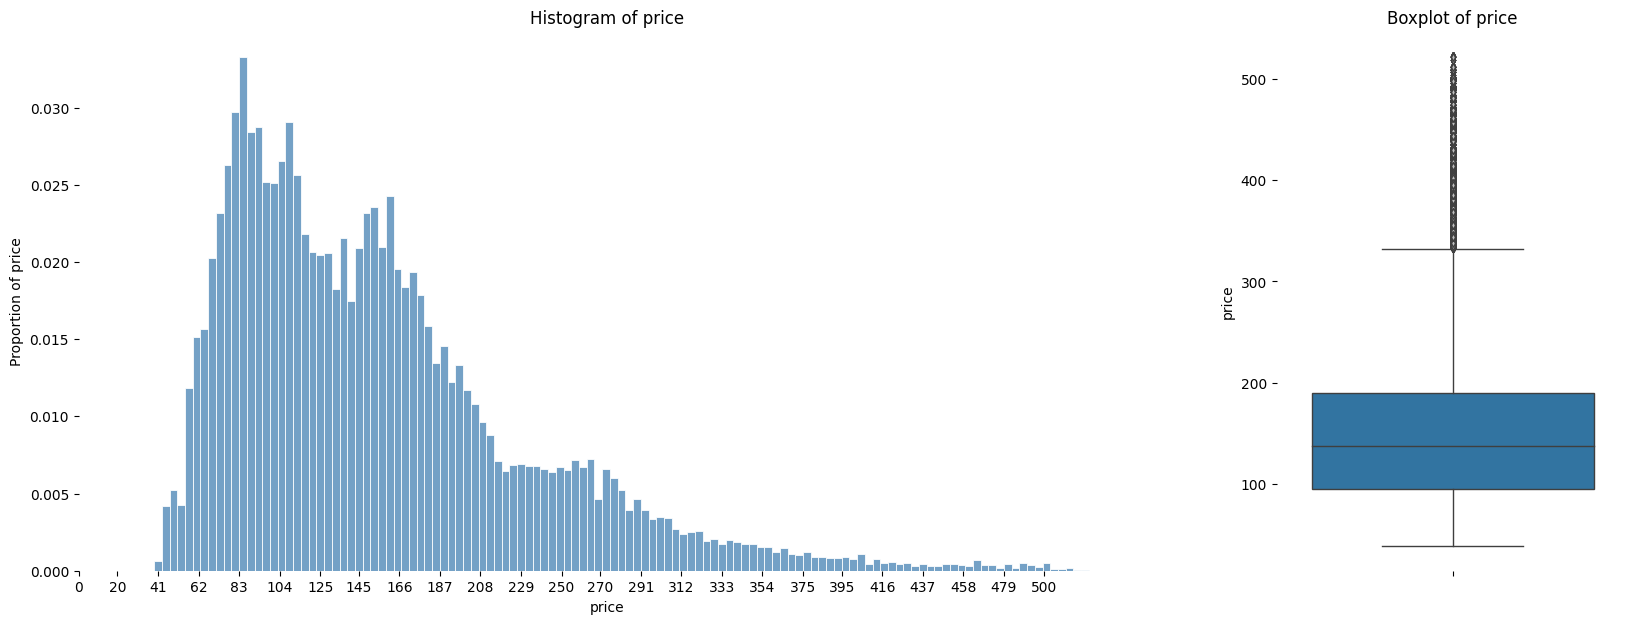

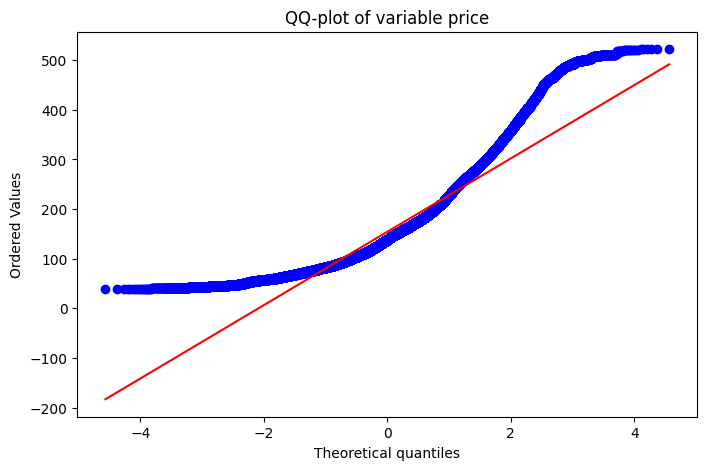

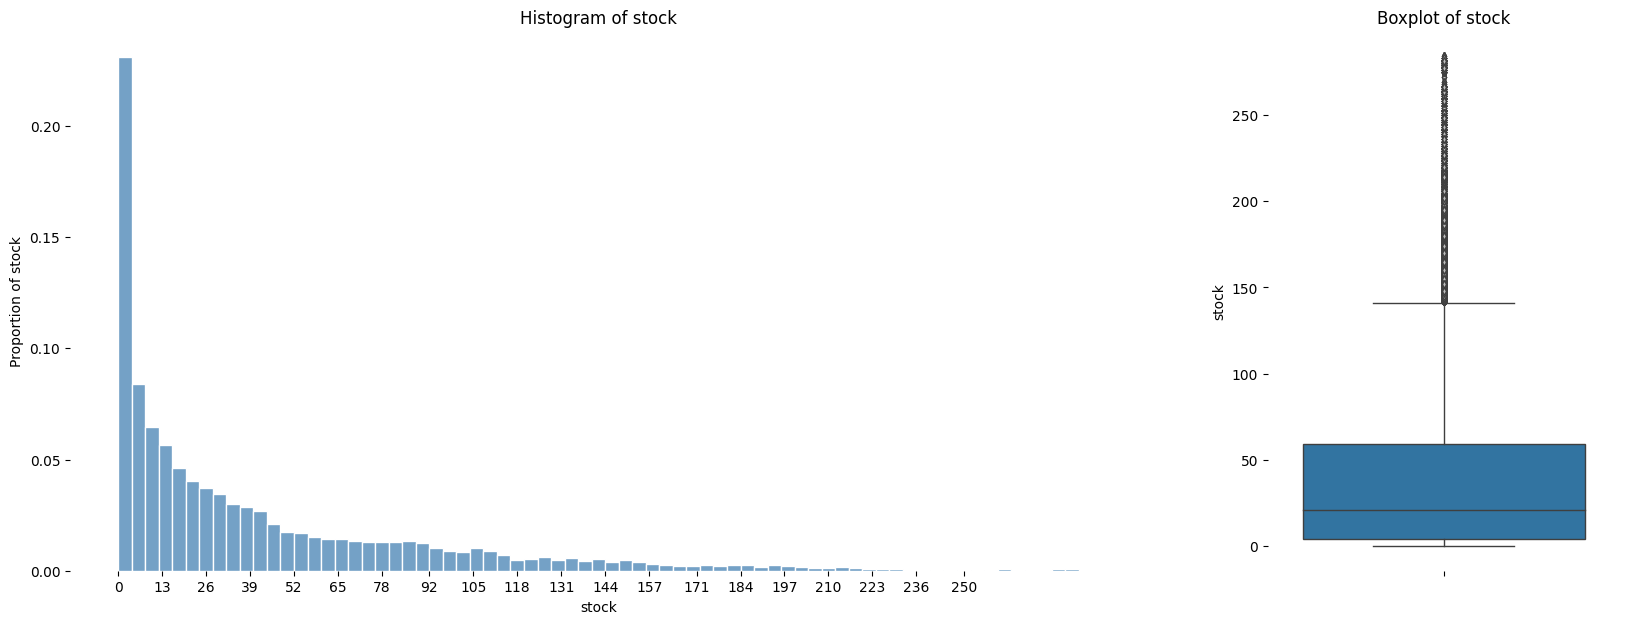

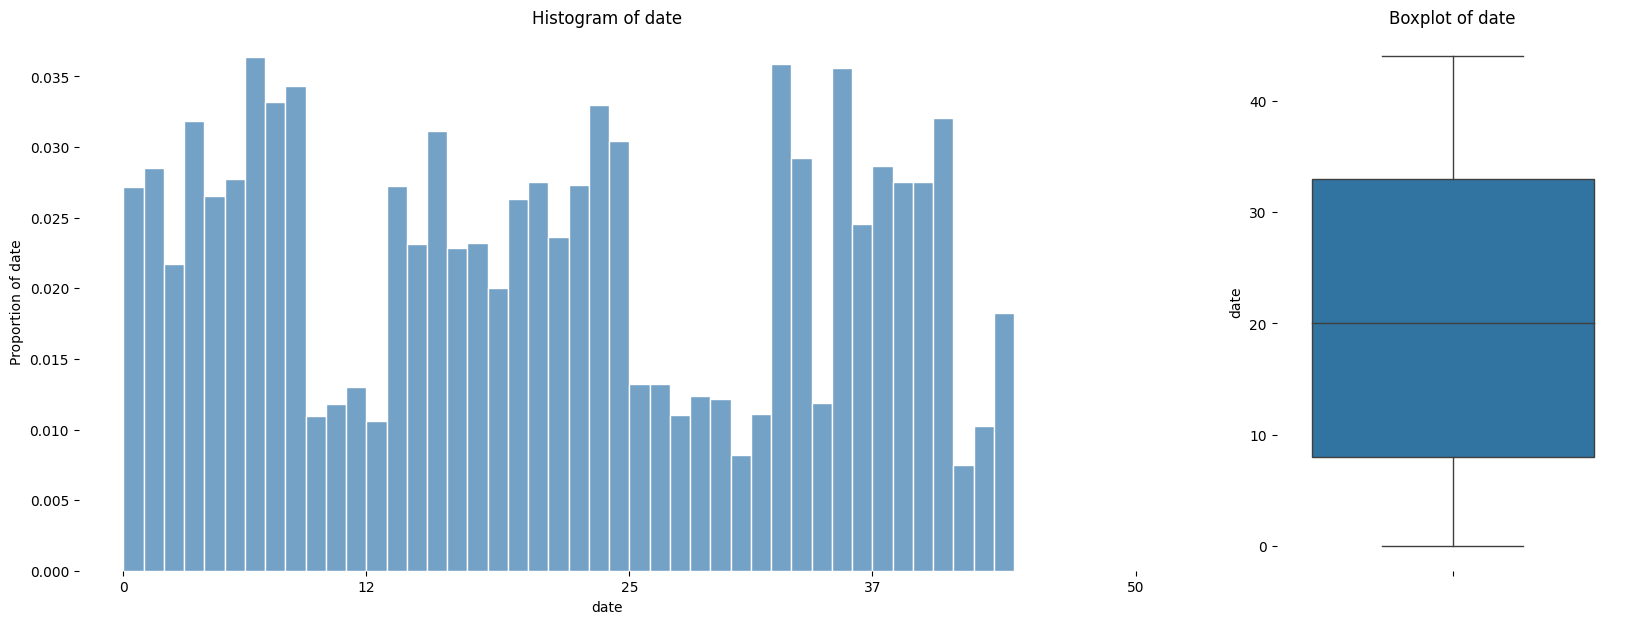

In [13]:
plotHist("price", qqPlot = True)
plotHist("stock",start = 0, stop = 250, step = 20, qqPlot = False)
plotHist("date",start = 0, stop = 50, step = 5, bin_width = 1, qqPlot = False)

Avec les graphes ci-dessus, on voit que `Price` n'est pas une variable gaussienne (mais pourrait s'y apparenter) et `Stock` a davantage l'allure d'une variable exponentielle. La variable `date` ne semble pas avoir de structure particulière.  

### Transformations sur les variables quantitatives 

Nous allons tenter de rendre les variables quantitatives "plus gaussiennes" en leur appliquant des transformations.

In [14]:
# Variables à modifier pour rendre + gaussiennes 
pricing_requests["price"]=pricing_requests["price"].map(lambda x: sqrt(x))
pricing_requests["stock"]=pricing_requests["stock"].map(lambda x: log(x+1)) #log(x+1) car log(0) n'existe pas.

========== Distribution des variable après transformation: ==========


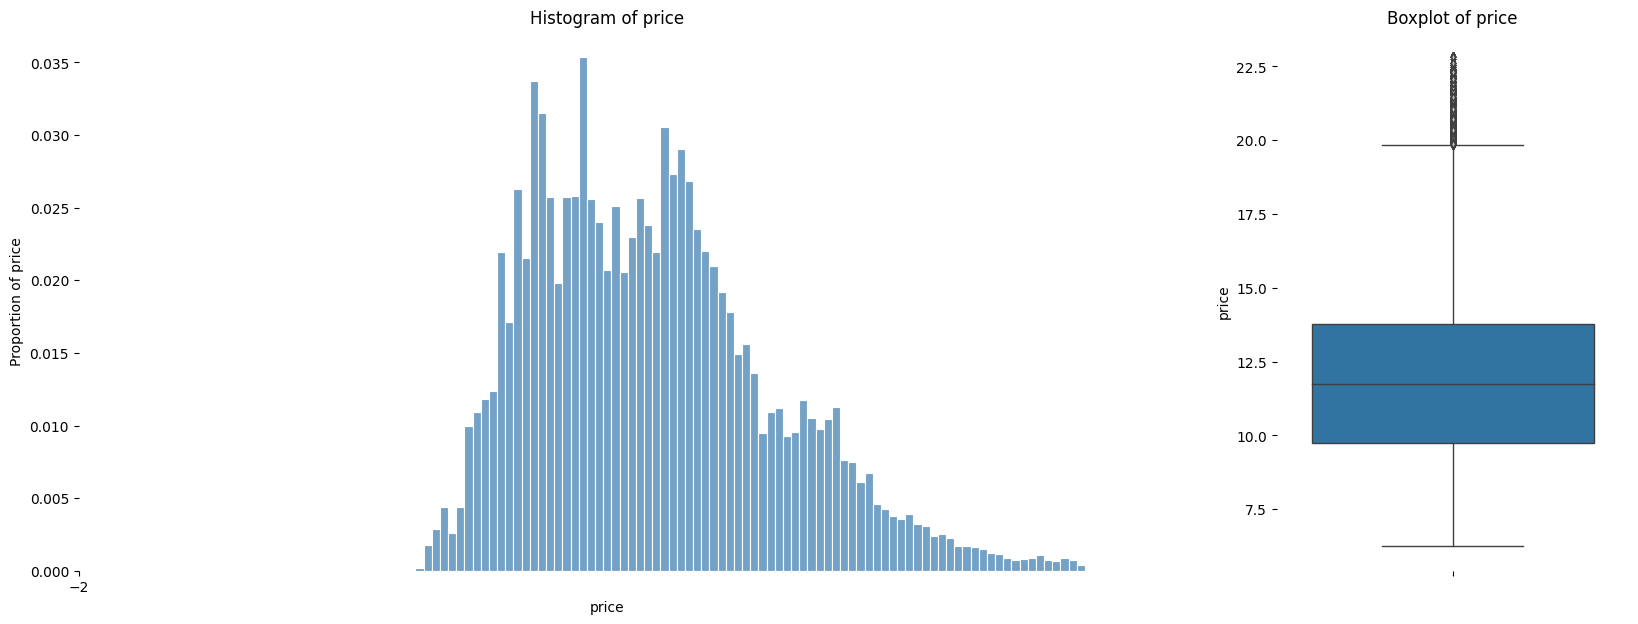

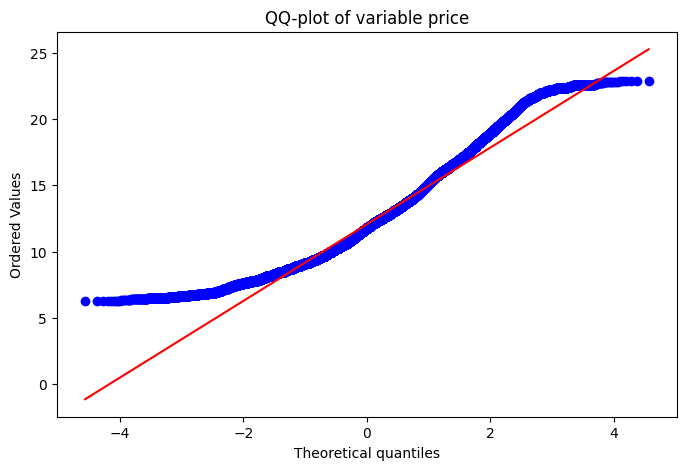

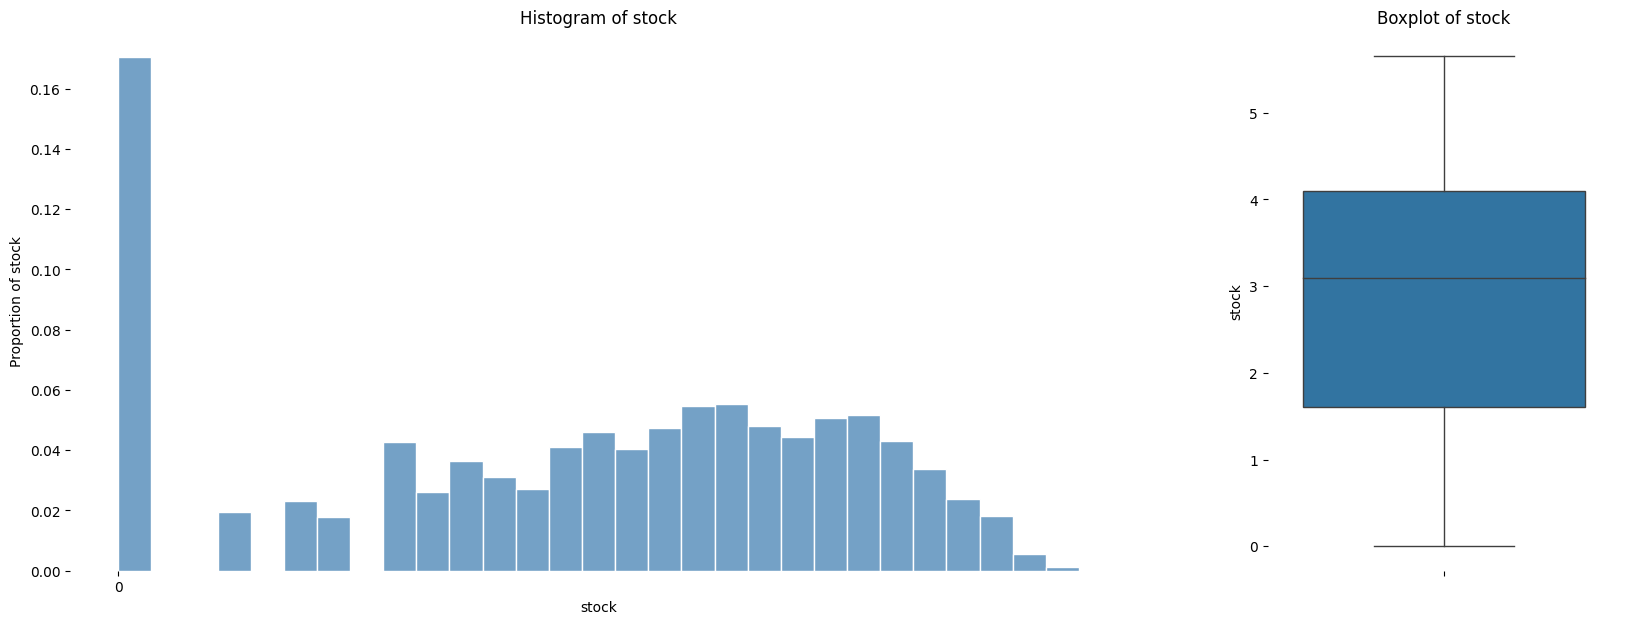

In [15]:
print("========== Distribution des variable après transformation: ==========")
plotHist("price", start = -2, stop = 20, step = 1, bin_width = .2, qqPlot = True)
plotHist("stock",start = 0, stop = 15, step = 1, bin_width = .2, qqPlot = False)

### Variable date

In [16]:
def plotDates():
    """
    Cette fonction trace la répartition de la variable date
    """
    dates_requests = pricing_requests[["request_number","date"]].drop_duplicates()
    
    fig, ax = plt.subplots(figsize=(15,6))

    counts, edges, bars = ax.hist(dates_requests.date,bins=len(dates_requests)//10, density=False,alpha = .5)

    ax.bar_label(bars,padding = 1,size = 12)
    ax.set_xticks(np.arange(0,41))
    ax.set_title("Nombre d'avatars par date de requêtes réalisée")
    ax.set_xlabel("valeur de date")
    ax.set_ylabel("nombre d'occurrences")

    ax.spines[['top','right','left']].set_visible(False)
    plt.show()

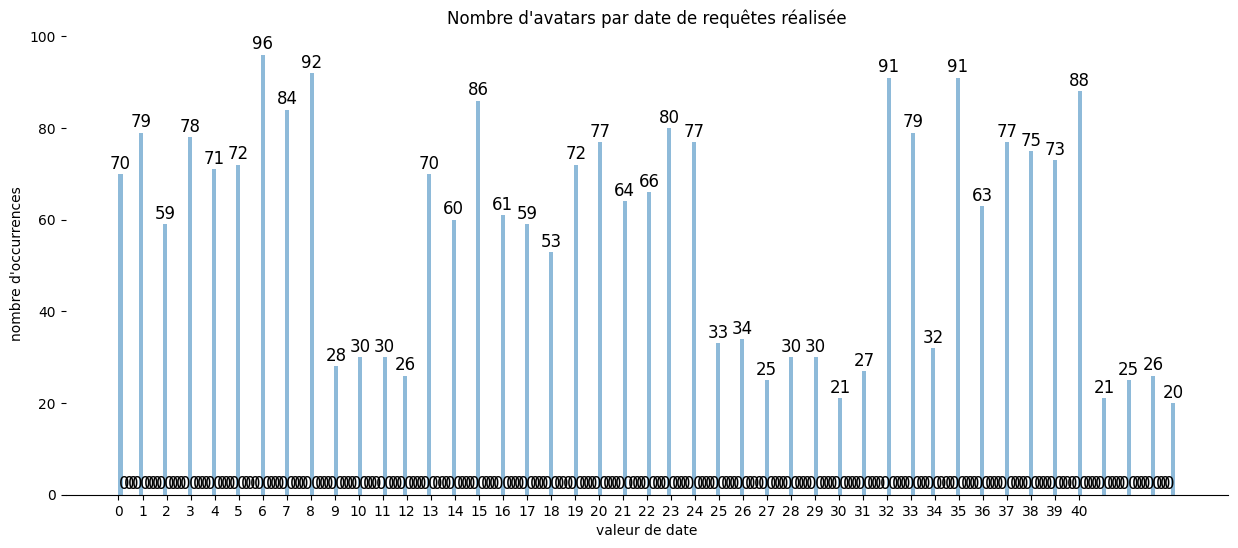

In [17]:
plotDates()

### Transformation des données pour le ML

In [18]:
# Variables explicatives
#-------------------------------------------------
# Liste des variables categorical: 
cat_list1 = ["city", "language", "brand","mobile","parking","pool","children_policy"] #avec brand
cat_list2 = ["city", "language", "group","mobile","parking","pool","children_policy"] #avec group
cat_list3 = ["city", "language", "brand", "group","mobile","parking","pool","children_policy"] #avec brand & group

# Liste des variables quantitatives: 
quant_list1 = ["hotel_id", "stock","request_number", "date"] #on a enlevé avatar_id et price (=variable à expliquer)

# Création de la dataframe train
requests_pricingDum  = pd.get_dummies(pricing_requests[cat_list3],drop_first = True)
request_pricingQuant = pricing_requests[quant_list1]

dfC = pd.concat([requests_pricingDum,request_pricingQuant],axis=1)
dfC.columns

Index(['city_copenhagen', 'city_madrid', 'city_paris', 'city_rome',
       'city_sofia', 'city_valletta', 'city_vienna', 'city_vilnius',
       'language_belgian', 'language_bulgarian', 'language_croatian',
       'language_cypriot', 'language_czech', 'language_danish',
       'language_dutch', 'language_estonian', 'language_finnish',
       'language_french', 'language_german', 'language_greek',
       'language_hungarian', 'language_irish', 'language_italian',
       'language_latvian', 'language_lithuanian', 'language_luxembourgish',
       'language_maltese', 'language_polish', 'language_portuguese',
       'language_romanian', 'language_slovakian', 'language_slovene',
       'language_spanish', 'language_swedish', 'brand_Ardisson',
       'brand_Boss Western', 'brand_Chill Garden Inn', 'brand_Corlton',
       'brand_CourtYord', 'brand_Ibas', 'brand_Independant',
       'brand_J.Halliday Inn', 'brand_Marcure', 'brand_Morriot',
       'brand_Navatel', 'brand_Quadrupletree', 'brand_R

In [19]:
# Variable à expliquer 
#-------------------------------------------------
Y = pricing_requests["price"]

Il y a plusieurs façons de diviser notre dataset:


- **Méthode 1**: lorsque l'on a peu de données 

<font color = "blue"> ====================Training================== </font> | <font color = "green"> ====Testing==== </font>\
On se sert de l'échantillon Training pour entraîner notre modèle mais aussi pour tuner les paramètres du modèles et/ou effectuer une sélection de modèles avec la Cross-Validation.\
On ne touche au set de test qu'à la fin, pour obtenir la performance finale.

- **Méthode 2**: lorsque l'on a suffisamment de données 

<font color = "blue"> ===========Training========== </font> <font color = "orange"> ====Validation==== </font> | <font color = "green"> ====Testing==== </font>\
On se sert de l'échantillon Training pour entraîner notre modèle et on tune les paramètres du modèles et/ou effectue une sélection de modèle avec l'échantillon de Validation.\
On ne touche au set de test qu'à la fin, pour obtenir la performance finale. 


Comme nous avons suffisament de données, nous pouvons utiliser la méthode 2 est qui est pratique plus robuste.

In [20]:
# Construction de l'échantillon de test, échantillon de train et échantillon de validation
#-------------------------------------------------
X_train, X_test, Y_train, Y_test = train_test_split(dfC, Y, test_size=0.2, random_state=11)
X_train, X_val, Y_train, Y_val =  train_test_split(X_train, Y_train, test_size=0.25, random_state=11) # 0.25 x 0.8 = 0.2

In [21]:
print("X_train ---> taille: {} x {}".format(X_train.shape[0], X_train.shape[1]))
print("X_val   ---> taille: {}  x {}".format(X_val.shape[0], X_val.shape[1]))
print("X_test  ---> taille: {}  x {}".format(X_test.shape[0], X_test.shape[1]))

X_train ---> taille: 165606 x 63
X_val   ---> taille: 55203  x 63
X_test  ---> taille: 55203  x 63


In [22]:
# Standardisation des variables quantitatives 
#-------------------------------------------------
# standardisation
scaler = StandardScaler()

scaler.fit(X_train)
Xr_train = scaler.transform(X_train)
Xr_val = scaler.transform(X_val)
Xr_test = scaler.transform(X_test)

# transformation de Xr_train et Xr_test (numpy array) en dataframe
Xr_train = pd.DataFrame(Xr_train, index=X_train.index, columns=X_train.columns)
Xr_test = pd.DataFrame(Xr_test, index=X_test.index, columns=X_test.columns)
Xr_val = pd.DataFrame(Xr_val, index=X_val.index, columns=X_val.columns)



In [23]:
filename = 'Standard_Scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

### Feature Reduction

https://machinelearningmastery.com/feature-selection-with-categorical-data/ => mais il faut que la target variable soit aussi categorical...

#### Method 1: RFECV

RFE (`sklearn.feature_selection.RFE`) select features based on how they affect a particular model’s performance. RFE needs to be given the number of features to select.

It is possible to automatically select the number of features chosen by RFE. This can be achieved by performing cross-validation evaluation of different numbers of features and automatically selecting the number of features that resulted in the best mean score. The RFECV class implements this for us. Remark: the documentation of RFECV says that: "If the estimator is a classifier or if y is neither binary nor multiclass, sklearn.model_selection.KFold is used instead of StartifiedKFold"

Pour appliquer cette méthode, il faut définir un estimateur permettant de donner des `coef_` (ex: SVM, RF, linear regressor...) 

Etant donné qu'il y a beaucoup trop de données pour que la méthode RFECV fonctionne (crée pb espace mémoire), on sélectionne aléatoirement une proportion de données du dataset en espérant que cela représente la globalité des données présentes. 

In [24]:
def reduceDataset(X_t,Y_t,X_v,Y_v,k=10000,per=0.2):
    """
    Cette fonction tire aléatoirement sans remise k éléments dans les datasets donnés
    en argument afin d'en réduire la taille. 
    ---> inputs:
    * X_t,Y_t (pd.DafaFrame): datasets d'entraînement dont il faut réduire la taille. 
    * X_v,Y_v (pd.DafaFrame): datasets de validation dont il faut réduire la taille. 
    * k (int): nombre d'éléments tirés aléatoirement
    * per (float): pourcentage du dataset de validation par rapport au dataset d'entraînement.
    ---> outputs:
    * X_train_small,Y_train_small (pd.DafaFrame): datasets d'entraînement de taille réduite.
    * X_val_small,Y_val_small (pd.DafaFrame): datasets de validation de taille réduite.  
    """
    
    k_train = 10000
    k_val = int(k_train*per)

    indices_train = random.choices(X_t.index, k = k_train)
    indices_val = random.choices(X_v.index,k = k_val)

    X_train_small = X_t.loc[indices_train]
    Y_train_small = Y_t.loc[indices_train]

    X_val_small = X_v.loc[indices_val]
    Y_val_small = Y_v.loc[indices_val]
    
    return X_train_small, X_val_small, Y_train_small, Y_val_small

In [25]:
# Réduction des datasets standardisés
#----------------------------------------------
Xr_train_small, Xr_val_small, Yr_train_small, Yr_val_small = reduceDataset(
    Xr_train,Y_train,Xr_val,Y_val,k=100000,per=0.2)

print("Taille des datasets réduits:")
print("Xr_train_small ---> taille: {} x {}".format(Xr_train_small.shape[0], Xr_train_small.shape[1]))
print("Xr_val_small   ---> taille: {}  x {}".format(Xr_val_small.shape[0], Xr_val_small.shape[1]))
#list(set(X_train_small.index).intersection(X_val_small.index)) #vérifier que l'intersection est vide

Taille des datasets réduits:
Xr_train_small ---> taille: 10000 x 63
Xr_val_small   ---> taille: 2000  x 63


In [26]:
from sklearn.model_selection import RepeatedKFold

In [27]:
# Automatically Select the Number of Features 
#----------------------------------------------
#----- create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=15)
# rfe = RFECV(estimator=DecisionTreeRegressor()) # RFECV automatically selects the number of features
model = DecisionTreeRegressor()
# model = SVR(kernel="poly")
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
#----- evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, Xr_train_small, Yr_train_small, 
                           scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
#----- report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -0.491 (0.029)


In [28]:
# Print out the  selected features in order of ranking
#------------------------------------------
rfe.fit(Xr_train_small, Yr_train_small)
from operator import itemgetter
features = np.array(Xr_train_small.columns.to_list())
print("Features in order of ranking:")
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)
print("-----------------------------------")
print("The selected {} features are:\n{}".format(rfe.n_features_,features[rfe.support_]))

Features in order of ranking:
1 city_copenhagen
1 city_madrid
1 city_sofia
1 city_vilnius
1 brand_Boss Western
1 brand_Chill Garden Inn
1 brand_Corlton
1 brand_Ibas
1 brand_Safitel
1 group_Independant
1 group_Yin Yang
1 pool_1
1 hotel_id
1 stock
1 date
2 brand_Navatel
3 brand_Ardisson
4 brand_Royal Lotus
5 city_paris
6 request_number
7 group_Boss Western
8 city_rome
9 parking_1
10 brand_Tripletree
11 brand_CourtYord
12 city_vienna
13 children_policy_1
14 brand_Marcure
15 brand_Morriot
16 brand_Quadrupletree
17 city_valletta
18 mobile_1
19 language_portuguese
20 language_finnish
21 language_latvian
22 language_greek
23 language_luxembourgish
24 language_hungarian
25 language_slovakian
26 language_romanian
27 language_irish
28 language_swedish
29 language_lithuanian
30 language_polish
31 language_danish
32 language_german
33 language_bulgarian
34 group_Morriott International
35 language_french
36 group_Chillton Worldwide
37 brand_J.Halliday Inn
38 language_estonian
39 language_czech
40 l

#### Method 2: 

Cette méthode permet d'eefectuer de la sélection de varible lorsque nous avons des variables explicatives qualitatives et une variable réponse aussi qualitative.\
Nous allons donc appliquer cette méthode uniquement aux variables qualitatives de notre jeu de données et nous allons transformer notre variable réponse qui est quantitative (prix) en une variable qualitative. 

Ici, pas besoin de réduire la taille des datasets car les calculs ne sont pas trop longs.

documentation: https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [29]:
def categorizeY(Y):
    """
    This function transforms Y (prices) into a categorical variable.
    ---> input:
    * Y (pd.Series): variable continue que l'on veut rendre discrète.
    ---> ouput: 
    * Y_cat (pd.Series): variable discrète. 
    """
    Y_cat = np.zeros(Y.shape).astype(int)

    Y_cat[np.where(Y < 10)] = 0
    Y_cat[np.where((10 <= Y) & (Y < 15))]  = 1
    Y_cat[np.where((15 <= Y) & (Y < 20))]  = 2
    Y_cat[np.where(20 <= Y)]  = 3

    Y_cat = pd.Categorical(Y_cat,ordered=True) 
    Y_cat = pd.Series(Y_cat)
    Y_cat.index = Y.index
    
    return Y_cat

In [30]:
# Transformation de la variable réponse en variable catégorielle
#----------------------------------------------
Y_train_c = categorizeY (Y_train)
Y_val_c = categorizeY (Y_val)

# On ne garde que les variables qualitatives
#----------------------------------------------
X_train_c = X_train[X_train.columns[:-4]]
X_val_c = X_val[X_val.columns[:-4]]

__Chi-Squared Feature Selection__


Pearson’s chi-squared statistical hypothesis test is an example of a test for independence between categorical variables.
The results of this test can be used for feature selection, where those features that are independent of the target variable can be removed from the dataset.

Plus le Chi2-score est élevé et plus la feature est importante

In [31]:
# Feature selection de k paramètres basée sur le test du Chi2
#----------------------------------------------
chi_2 = SelectKBest(score_func=chi2, k='all') #mettre k='all' si on veut sélectionner toutes les features
chi_2.fit(X_train_c, Y_train_c)

# Dataframe contenant les Chi2-scores de chaque features
#----------------------------------------------
dfScoresChi2 = pd.DataFrame()
dfScoresChi2["feature"] = chi_2.feature_names_in_
dfScoresChi2["score"] =  chi_2.scores_

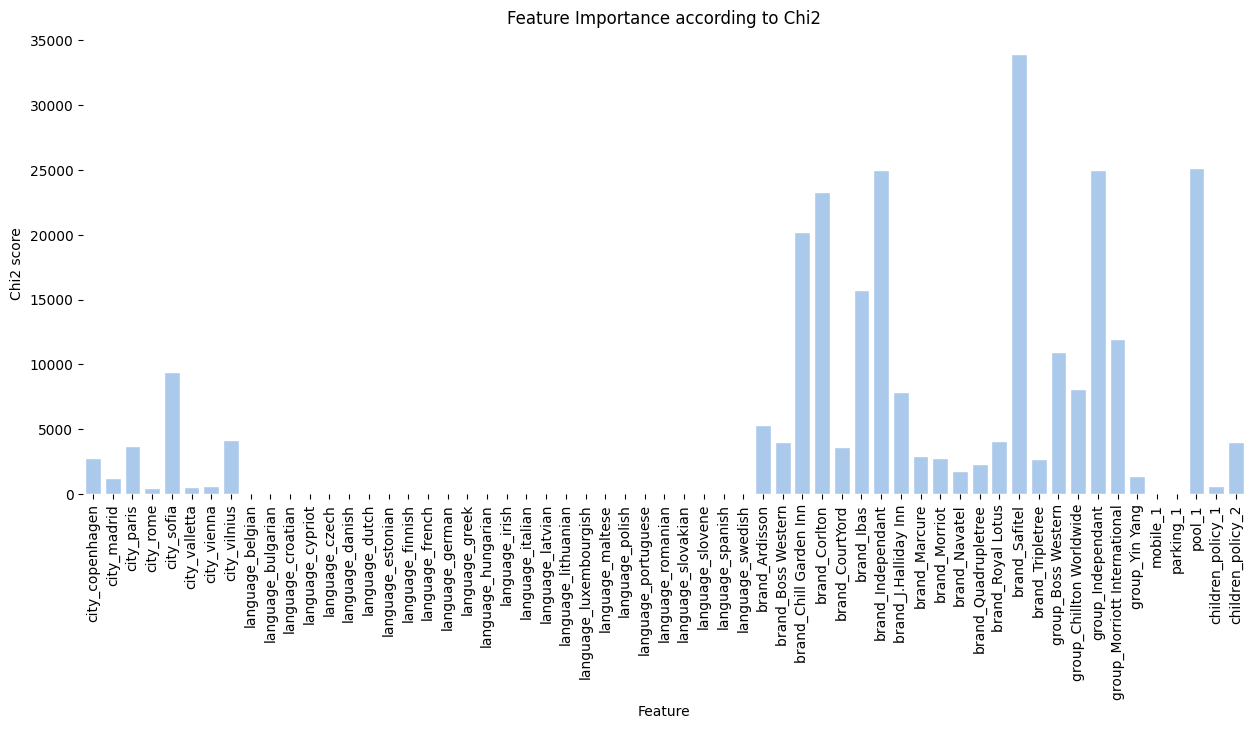

In [32]:
# Tracé de l'importance des features: 
# plus la valeur du score est elevée et plus la feature est importante. 
#----------------------------------------------
f, ax = plt.subplots(figsize=(15, 6))
sns.set_color_codes('pastel')

sns.barplot(ax = ax, x = 'feature', y = 'score', data = dfScoresChi2,
            label = '', color = 'b', edgecolor = 'w')
ax.set(ylabel="Chi2 score", xlabel="Feature")
ax.tick_params(axis='x', rotation=90)
ax.set_title('Feature Importance according to Chi2')
sns.despine(left = True, bottom = True) #remove graph frame
plt.show()

Avec le graphique ci-dessus, on voit que l'on peut sélectionner environ 16 features.

In [33]:
# Sélection de k=16 features avec le Chi2
#----------------------------------------------
chi_2 = SelectKBest(score_func=chi2, k=16) #mettre k='all' si on veut sélectionner toutes les features
chi_2.fit(X_train_c, Y_train_c)
# X_train_chi2 = chi_2.transform(X_train_c)
# X_val_chi2 = chi_2.transform(X_cal_c)

# Affichage des k features sélectionnées 
#----------------------------------------------
chi2_selected = chi_2.get_support(indices=True)
X_train_chi2 = X_train_c.iloc[:,chi2_selected]
X_val_chi2 = X_val_c.iloc[:,chi2_selected]

In [34]:
X_train_chi2.head()

,city_sofia,city_vilnius,brand_Ardisson,brand_Boss Western,brand_Chill Garden Inn,brand_Corlton,brand_Ibas,brand_Independant,brand_J.Halliday Inn,brand_Royal Lotus,brand_Safitel,group_Boss Western,group_Chillton Worldwide,group_Independant,group_Morriott International,pool_1
203094,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
64724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267495,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
264154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
241898,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


__Mutual Information Feature Selection__ 

Mutual information from the field of information theory is the application of information gain (typically used in the construction of decision trees) to feature selection.

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

In [35]:
# Feature selection de k paramètres basée sur le MI 
#----------------------------------------------
mi = SelectKBest(score_func=mutual_info_classif, k='all') #mettre k='all' si on veut sélectionner toutes les features
mi.fit(X_train_c, Y_train_c)

# Dataframe contenant les Chi2-scores de chaque features
#----------------------------------------------
dfScoresMi = pd.DataFrame()
dfScoresMi["feature"] = mi.feature_names_in_
dfScoresMi["score"] =  mi.scores_

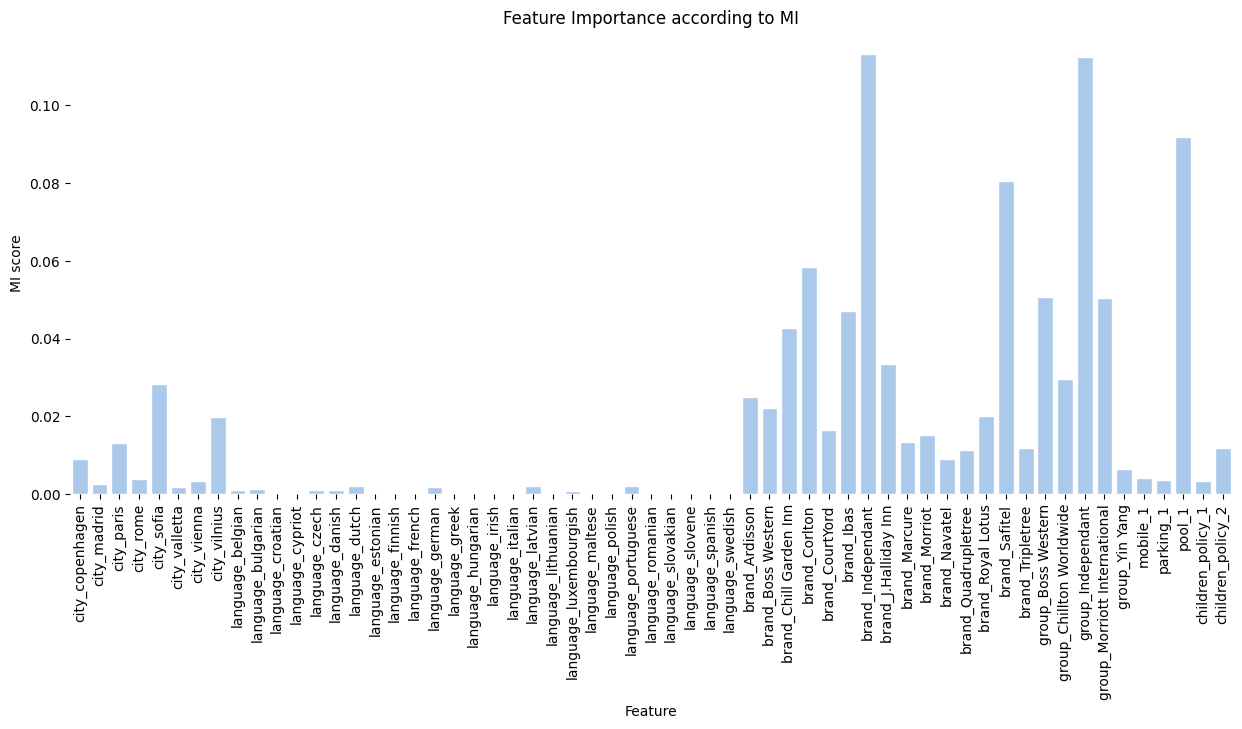

In [36]:
# Tracé de l'importance des features: 
# plus la valeur du score est elevée et plus la feature est importante. 
#----------------------------------------------
f, ax = plt.subplots(figsize=(15, 6))
sns.set_color_codes('pastel')

sns.barplot(ax = ax, x = 'feature', y = 'score', data = dfScoresMi,
            label = '', color = 'b', edgecolor = 'w')
ax.set(ylabel="MI score", xlabel="Feature")
ax.tick_params(axis='x', rotation=90)
ax.set_title('Feature Importance according to MI')
sns.despine(left = True, bottom = True) #remove graph frame
plt.show()

Avec le graphique ci-dessus, on voit que l'on peut sélectionner environ 11 features.

In [37]:
# Sélection de k=16 features avec le Chi2
#----------------------------------------------
mi = SelectKBest(score_func=mutual_info_classif, k=11) #mettre k='all' si on veut sélectionner toutes les features
mi.fit(X_train_c, Y_train_c)

# Affichage des k features sélectionnées 
#----------------------------------------------
mi_selected = mi.get_support(indices=True)
X_train_mi = X_train_c.iloc[:,mi_selected]
X_val_mi = X_val_c.iloc[:,mi_selected]

KeyboardInterrupt: 

### Algo 1: XGBoost

In [ ]:
#autre version avec gradient boosting 
"""params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, Y_train)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)"""

In [ ]:
"""for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(Y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)

#plt.axvline((np.arange(params["n_estimators"]) + 1)[np.argmin(test_score)])
plt.axvline(200)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance/squared error loss")
fig.tight_layout()
plt.show()"""

In [ ]:
#!pip install xgboost==1.0.1

In [47]:
# create an xgboost regression model
import xgboost as xgb
#on utilise XGboost car il est considéré comme plus précis et plus fiable queGBM (de plus il utilise la prallélisation)

#on définit le modèle
model = xgb.XGBRegressor(n_estimators=2000, max_depth=10, min_child_weight=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.7, nthread=4, objective = 'reg:squarederror', silent=0)

#800
#on entraine le modèle 
model.fit(Xr_train,Y_train) #Xr = données normalisée

#modèle qui a donné un bon résultat 

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=0, subsample=0.9, tree_method=None,
             validate_parameters=False, verbosity=None)

In [49]:
from sklearn.metrics import mean_squared_error
ypred = model.predict(Xr_test) #on prédit sur Xr_test
mse = mean_squared_error(Y_test**2, ypred**2) 
#Calcul du mse entre les prédictions. ATTENTION : les mettre au carré 
#car le prix doit être au carré car on a fait une transformation racine carrée
print("MSE: %.2f" % mse)
print(model.score(Xr_test, Y_test))# score

MSE: 15.32
0.9979074976917478


In [48]:
#save le modèle :
if tune_hyperparamters :
    filename = model_folder + '1105_X_gboost_tuned_model_toutes_les_var_800_arbres.sav' # enregistrement du modèle dans X_gboost
    pickle.dump(model, open(filename, 'wb')) # enregistrement du fichier 

In [ ]:
model

In [ ]:
loaded_model = pickle.load(open(model_folder + filename, 'rb')) #on peut ensuite le recharger 
result = loaded_model.score(Xr_test, Y_test) #score entre les prédictions et Y_test
print(result)

In [ ]:
from sklearn.model_selection import GridSearchCV

[0]	validation_0-rmse:10.76212	validation_1-rmse:10.76542
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:9.71246	validation_1-rmse:9.71670
[2]	validation_0-rmse:8.77031	validation_1-rmse:8.77526
[3]	validation_0-rmse:7.92145	validation_1-rmse:7.92686
[4]	validation_0-rmse:7.16233	validation_1-rmse:7.16844
[5]	validation_0-rmse:6.48124	validation_1-rmse:6.48741
[6]	validation_0-rmse:5.86834	validation_1-rmse:5.87494
[7]	validation_0-rmse:5.32095	validation_1-rmse:5.32718
[8]	validation_0-rmse:4.82669	validation_1-rmse:4.83339
[9]	validation_0-rmse:4.38486	validation_1-rmse:4.39137
[10]	validation_0-rmse:3.98250	validation_1-rmse:3.98930
[11]	validation_0-rmse:3.62383	validation_1-rmse:3.63102
[12]	validation_0-rmse:3.30229	validation_1-rmse:3.30886
[13]	validation_0-rmse:3.01536	validation_1-rmse:3.02205
[14]	validation_0-rmse:2.76027	validation_1-rmse:2.

[141]	validation_0-rmse:0.53586	validation_1-rmse:0.54314
[142]	validation_0-rmse:0.53538	validation_1-rmse:0.54277
[143]	validation_0-rmse:0.53502	validation_1-rmse:0.54248
[144]	validation_0-rmse:0.53476	validation_1-rmse:0.54228
[145]	validation_0-rmse:0.53392	validation_1-rmse:0.54148
[146]	validation_0-rmse:0.53181	validation_1-rmse:0.53918
[147]	validation_0-rmse:0.52998	validation_1-rmse:0.53732
[148]	validation_0-rmse:0.52946	validation_1-rmse:0.53681
[149]	validation_0-rmse:0.52713	validation_1-rmse:0.53469
[150]	validation_0-rmse:0.52567	validation_1-rmse:0.53311
[151]	validation_0-rmse:0.52323	validation_1-rmse:0.53080
[152]	validation_0-rmse:0.52125	validation_1-rmse:0.52890
[153]	validation_0-rmse:0.52058	validation_1-rmse:0.52832
[154]	validation_0-rmse:0.52021	validation_1-rmse:0.52799
[155]	validation_0-rmse:0.51847	validation_1-rmse:0.52624
[156]	validation_0-rmse:0.51710	validation_1-rmse:0.52494
[157]	validation_0-rmse:0.51689	validation_1-rmse:0.52480
[158]	validati

[283]	validation_0-rmse:0.40147	validation_1-rmse:0.41209
[284]	validation_0-rmse:0.40059	validation_1-rmse:0.41106
[285]	validation_0-rmse:0.39827	validation_1-rmse:0.40887
[286]	validation_0-rmse:0.39747	validation_1-rmse:0.40811
[287]	validation_0-rmse:0.39740	validation_1-rmse:0.40807
[288]	validation_0-rmse:0.39726	validation_1-rmse:0.40797
[289]	validation_0-rmse:0.39605	validation_1-rmse:0.40687
[290]	validation_0-rmse:0.39593	validation_1-rmse:0.40684
[291]	validation_0-rmse:0.39542	validation_1-rmse:0.40629
[292]	validation_0-rmse:0.39431	validation_1-rmse:0.40516
[293]	validation_0-rmse:0.39266	validation_1-rmse:0.40361
[294]	validation_0-rmse:0.39201	validation_1-rmse:0.40298
[295]	validation_0-rmse:0.39061	validation_1-rmse:0.40164
[296]	validation_0-rmse:0.39047	validation_1-rmse:0.40150
[297]	validation_0-rmse:0.38997	validation_1-rmse:0.40096
[298]	validation_0-rmse:0.38750	validation_1-rmse:0.39870
[299]	validation_0-rmse:0.38738	validation_1-rmse:0.39863
[300]	validati

[425]	validation_0-rmse:0.32075	validation_1-rmse:0.33382
[426]	validation_0-rmse:0.32033	validation_1-rmse:0.33342
[427]	validation_0-rmse:0.31883	validation_1-rmse:0.33175
[428]	validation_0-rmse:0.31758	validation_1-rmse:0.33061
[429]	validation_0-rmse:0.31746	validation_1-rmse:0.33050
[430]	validation_0-rmse:0.31653	validation_1-rmse:0.32964
[431]	validation_0-rmse:0.31602	validation_1-rmse:0.32914
[432]	validation_0-rmse:0.31595	validation_1-rmse:0.32907
[433]	validation_0-rmse:0.31550	validation_1-rmse:0.32869
[434]	validation_0-rmse:0.31505	validation_1-rmse:0.32827
[435]	validation_0-rmse:0.31452	validation_1-rmse:0.32768
[436]	validation_0-rmse:0.31425	validation_1-rmse:0.32743
[437]	validation_0-rmse:0.31405	validation_1-rmse:0.32723
[438]	validation_0-rmse:0.31401	validation_1-rmse:0.32721
[439]	validation_0-rmse:0.31300	validation_1-rmse:0.32627
[440]	validation_0-rmse:0.31218	validation_1-rmse:0.32546
[441]	validation_0-rmse:0.31205	validation_1-rmse:0.32532
[442]	validati

[567]	validation_0-rmse:0.27257	validation_1-rmse:0.28742
[568]	validation_0-rmse:0.27247	validation_1-rmse:0.28735
[569]	validation_0-rmse:0.27232	validation_1-rmse:0.28723
[570]	validation_0-rmse:0.27228	validation_1-rmse:0.28722
[571]	validation_0-rmse:0.27226	validation_1-rmse:0.28722
[572]	validation_0-rmse:0.27207	validation_1-rmse:0.28701
[573]	validation_0-rmse:0.27203	validation_1-rmse:0.28698
[574]	validation_0-rmse:0.27198	validation_1-rmse:0.28695
[575]	validation_0-rmse:0.27194	validation_1-rmse:0.28694
[576]	validation_0-rmse:0.27189	validation_1-rmse:0.28692
[577]	validation_0-rmse:0.27186	validation_1-rmse:0.28690
[578]	validation_0-rmse:0.27179	validation_1-rmse:0.28683
[579]	validation_0-rmse:0.27177	validation_1-rmse:0.28682
[580]	validation_0-rmse:0.27153	validation_1-rmse:0.28657
[581]	validation_0-rmse:0.27140	validation_1-rmse:0.28642
[582]	validation_0-rmse:0.27122	validation_1-rmse:0.28628
[583]	validation_0-rmse:0.27104	validation_1-rmse:0.28613
[584]	validati

[709]	validation_0-rmse:0.24601	validation_1-rmse:0.26266
[710]	validation_0-rmse:0.24589	validation_1-rmse:0.26257
[711]	validation_0-rmse:0.24583	validation_1-rmse:0.26253
[712]	validation_0-rmse:0.24564	validation_1-rmse:0.26235
[713]	validation_0-rmse:0.24553	validation_1-rmse:0.26226
[714]	validation_0-rmse:0.24542	validation_1-rmse:0.26216
[715]	validation_0-rmse:0.24530	validation_1-rmse:0.26205
[716]	validation_0-rmse:0.24526	validation_1-rmse:0.26204
[717]	validation_0-rmse:0.24516	validation_1-rmse:0.26197
[718]	validation_0-rmse:0.24501	validation_1-rmse:0.26184
[719]	validation_0-rmse:0.24499	validation_1-rmse:0.26183
[720]	validation_0-rmse:0.24477	validation_1-rmse:0.26161
[721]	validation_0-rmse:0.24462	validation_1-rmse:0.26147
[722]	validation_0-rmse:0.24449	validation_1-rmse:0.26136
[723]	validation_0-rmse:0.24432	validation_1-rmse:0.26121
[724]	validation_0-rmse:0.24428	validation_1-rmse:0.26118
[725]	validation_0-rmse:0.24423	validation_1-rmse:0.26116
[726]	validati

[851]	validation_0-rmse:0.23144	validation_1-rmse:0.25067
[852]	validation_0-rmse:0.23141	validation_1-rmse:0.25066
[853]	validation_0-rmse:0.23138	validation_1-rmse:0.25063
[854]	validation_0-rmse:0.23125	validation_1-rmse:0.25052
[855]	validation_0-rmse:0.23118	validation_1-rmse:0.25044
[856]	validation_0-rmse:0.23096	validation_1-rmse:0.25022
[857]	validation_0-rmse:0.23092	validation_1-rmse:0.25021
[858]	validation_0-rmse:0.23088	validation_1-rmse:0.25019
[859]	validation_0-rmse:0.23069	validation_1-rmse:0.25003
[860]	validation_0-rmse:0.23066	validation_1-rmse:0.25002
[861]	validation_0-rmse:0.23062	validation_1-rmse:0.25000
[862]	validation_0-rmse:0.23058	validation_1-rmse:0.24999
[863]	validation_0-rmse:0.23039	validation_1-rmse:0.24984
[864]	validation_0-rmse:0.23027	validation_1-rmse:0.24975
[865]	validation_0-rmse:0.23014	validation_1-rmse:0.24963
[866]	validation_0-rmse:0.22983	validation_1-rmse:0.24935
[867]	validation_0-rmse:0.22937	validation_1-rmse:0.24891
[868]	validati

[993]	validation_0-rmse:0.22071	validation_1-rmse:0.24257
[994]	validation_0-rmse:0.22069	validation_1-rmse:0.24258
[995]	validation_0-rmse:0.22065	validation_1-rmse:0.24257
[996]	validation_0-rmse:0.22063	validation_1-rmse:0.24256
[997]	validation_0-rmse:0.22061	validation_1-rmse:0.24255
[998]	validation_0-rmse:0.22058	validation_1-rmse:0.24255
[999]	validation_0-rmse:0.22056	validation_1-rmse:0.24255
[1000]	validation_0-rmse:0.22051	validation_1-rmse:0.24255
[1001]	validation_0-rmse:0.22048	validation_1-rmse:0.24255
[1002]	validation_0-rmse:0.22046	validation_1-rmse:0.24254
[1003]	validation_0-rmse:0.22043	validation_1-rmse:0.24253
[1004]	validation_0-rmse:0.22040	validation_1-rmse:0.24252
[1005]	validation_0-rmse:0.22037	validation_1-rmse:0.24251
[1006]	validation_0-rmse:0.22035	validation_1-rmse:0.24250
[1007]	validation_0-rmse:0.22032	validation_1-rmse:0.24250
[1008]	validation_0-rmse:0.22029	validation_1-rmse:0.24250
[1009]	validation_0-rmse:0.22026	validation_1-rmse:0.24249
[101

[1132]	validation_0-rmse:0.21335	validation_1-rmse:0.23754
[1133]	validation_0-rmse:0.21319	validation_1-rmse:0.23736
[1134]	validation_0-rmse:0.21318	validation_1-rmse:0.23735
[1135]	validation_0-rmse:0.21313	validation_1-rmse:0.23733
[1136]	validation_0-rmse:0.21307	validation_1-rmse:0.23727
[1137]	validation_0-rmse:0.21306	validation_1-rmse:0.23727
[1138]	validation_0-rmse:0.21303	validation_1-rmse:0.23726
[1139]	validation_0-rmse:0.21300	validation_1-rmse:0.23725
[1140]	validation_0-rmse:0.21289	validation_1-rmse:0.23718
[1141]	validation_0-rmse:0.21287	validation_1-rmse:0.23718
[1142]	validation_0-rmse:0.21281	validation_1-rmse:0.23714
[1143]	validation_0-rmse:0.21279	validation_1-rmse:0.23714
[1144]	validation_0-rmse:0.21276	validation_1-rmse:0.23714
[1145]	validation_0-rmse:0.21272	validation_1-rmse:0.23712
[1146]	validation_0-rmse:0.21270	validation_1-rmse:0.23712
[1147]	validation_0-rmse:0.21268	validation_1-rmse:0.23711
[1148]	validation_0-rmse:0.21263	validation_1-rmse:0.237

[1271]	validation_0-rmse:0.20217	validation_1-rmse:0.22839
[1272]	validation_0-rmse:0.20211	validation_1-rmse:0.22835
[1273]	validation_0-rmse:0.20209	validation_1-rmse:0.22834
[1274]	validation_0-rmse:0.20199	validation_1-rmse:0.22825
[1275]	validation_0-rmse:0.20179	validation_1-rmse:0.22806
[1276]	validation_0-rmse:0.20150	validation_1-rmse:0.22776
[1277]	validation_0-rmse:0.20118	validation_1-rmse:0.22745
[1278]	validation_0-rmse:0.20116	validation_1-rmse:0.22744
[1279]	validation_0-rmse:0.20113	validation_1-rmse:0.22744
[1280]	validation_0-rmse:0.20111	validation_1-rmse:0.22743
[1281]	validation_0-rmse:0.20108	validation_1-rmse:0.22743
[1282]	validation_0-rmse:0.20105	validation_1-rmse:0.22744
[1283]	validation_0-rmse:0.20103	validation_1-rmse:0.22743
[1284]	validation_0-rmse:0.20102	validation_1-rmse:0.22743
[1285]	validation_0-rmse:0.20102	validation_1-rmse:0.22743
[1286]	validation_0-rmse:0.20100	validation_1-rmse:0.22743
[1287]	validation_0-rmse:0.20093	validation_1-rmse:0.227

[1410]	validation_0-rmse:0.19031	validation_1-rmse:0.21819
[1411]	validation_0-rmse:0.19005	validation_1-rmse:0.21793
[1412]	validation_0-rmse:0.18993	validation_1-rmse:0.21780
[1413]	validation_0-rmse:0.18975	validation_1-rmse:0.21763
[1414]	validation_0-rmse:0.18953	validation_1-rmse:0.21741
[1415]	validation_0-rmse:0.18934	validation_1-rmse:0.21719
[1416]	validation_0-rmse:0.18922	validation_1-rmse:0.21709
[1417]	validation_0-rmse:0.18917	validation_1-rmse:0.21704
[1418]	validation_0-rmse:0.18915	validation_1-rmse:0.21703
[1419]	validation_0-rmse:0.18911	validation_1-rmse:0.21701
[1420]	validation_0-rmse:0.18903	validation_1-rmse:0.21697
[1421]	validation_0-rmse:0.18898	validation_1-rmse:0.21693
[1422]	validation_0-rmse:0.18895	validation_1-rmse:0.21692
[1423]	validation_0-rmse:0.18892	validation_1-rmse:0.21691
[1424]	validation_0-rmse:0.18890	validation_1-rmse:0.21690
[1425]	validation_0-rmse:0.18889	validation_1-rmse:0.21690
[1426]	validation_0-rmse:0.18885	validation_1-rmse:0.216

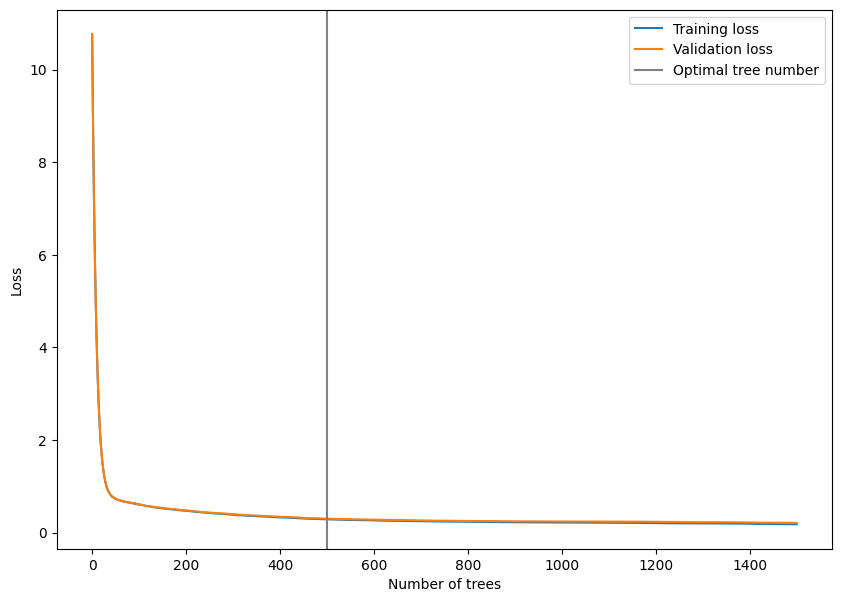

In [42]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
if tune_hyperparamters:
#la première étape est de choisir le nombre d'arbres que l'on veut utiliser dans notre modèle de boosting. 
#Pour ce faire, on va faire de l'early stopping pour trouver le nombre d'arbres à conserver 
#de manière à ne pas overfitter 
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=3000, max_depth=6, learning_rate=0.1)
    model.fit(Xr_train, Y_train, 
                eval_set=[(Xr_train, Y_train), (Xr_val, Y_val)], 
                early_stopping_rounds=20) 

    results = model.evals_result()

    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["rmse"], label="Training loss")
    plt.plot(results["validation_1"]["rmse"], label="Validation loss")
    plt.axvline(500, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    
# la figure est tout en bas


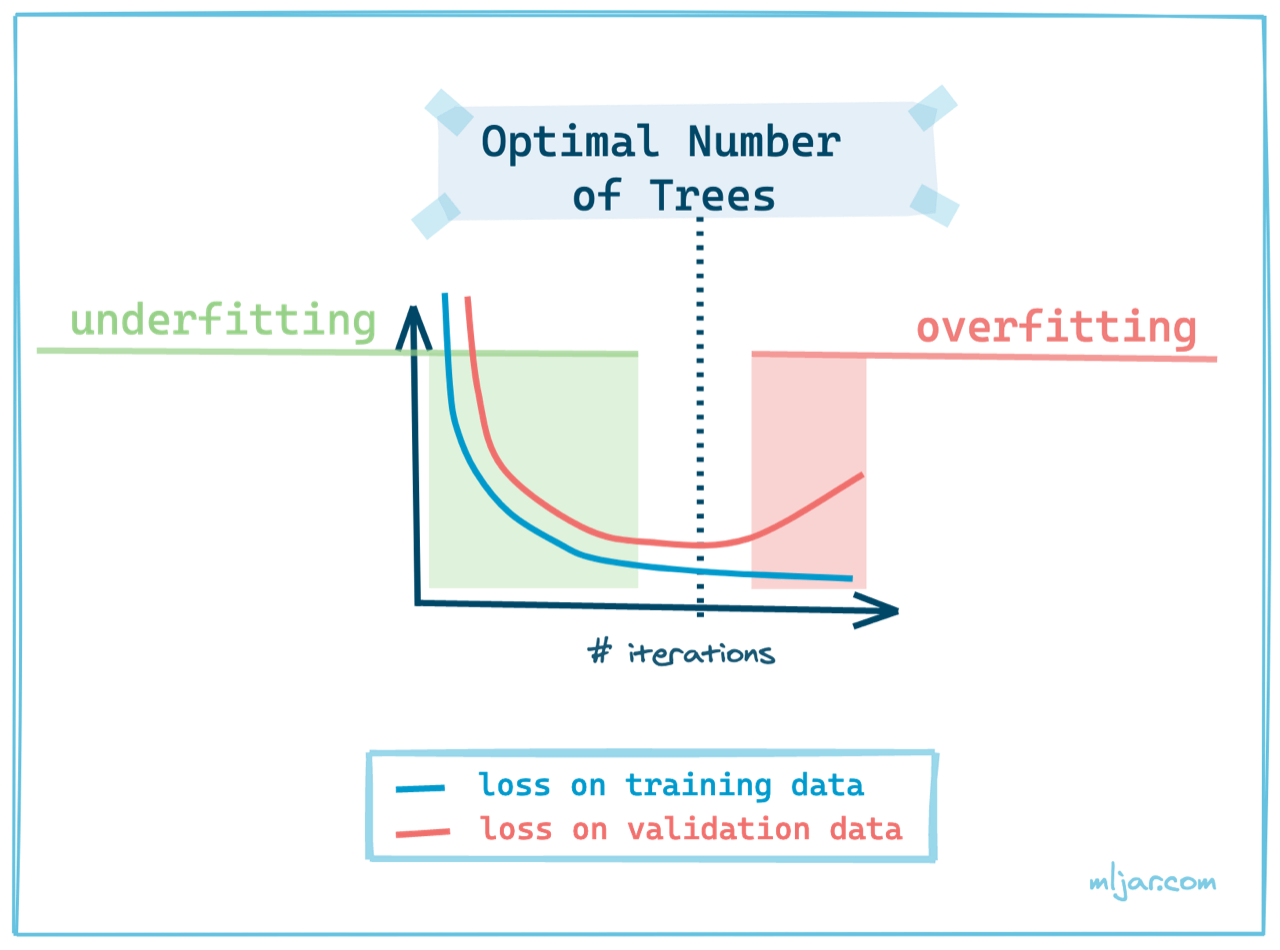

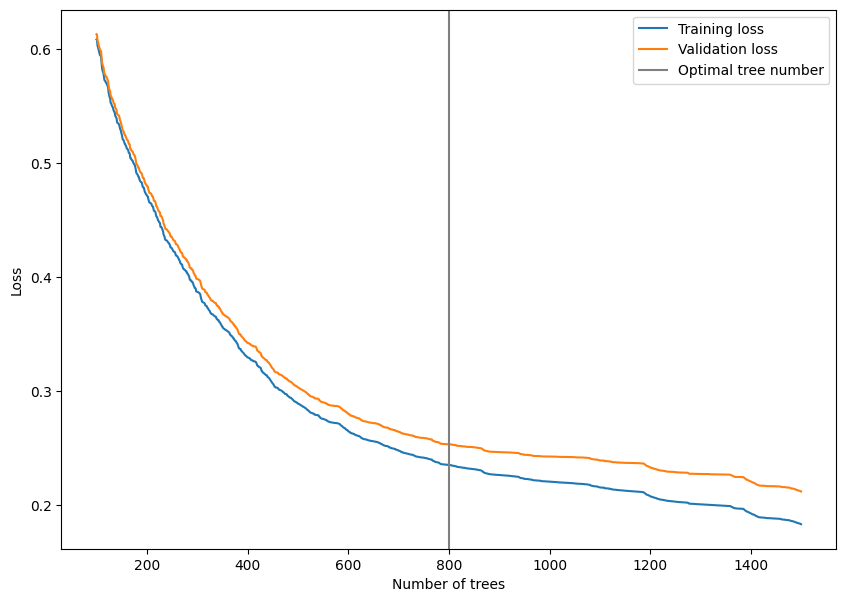

In [45]:
if tune_hyperparamters:
    plt.figure(figsize=(10,7))
    begin=100
    x=np.arange(begin, 3000, 1)
    plt.plot(x, results["validation_0"]["rmse"][begin:], label="Training loss")
    plt.plot(x, results["validation_1"]["rmse"][begin:], label="Validation loss")
    plt.axvline(800, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()

On constate  que la méthode de early stopping ne donne pas des résultats très prononcés. On a que l'erreur de validation et de tests sont tr_s similaires, et ne divergent pas de manière aussi visibles qu'attendu. On est obligé de prendre un très grand nombre d'arbres pour observer le début de cette divergence. En zoomant, on choisit de fixer le nombre d'arbres à 500, de manière à limiter le surapprentissage. 

Ensuite, on réalise une K-fold validation de manière à trouver les paramètres permettant de maximiser la performance. Ici, nous avons préalablement fixé le nombre d'arbres et on a que on cherche à optimiser le taux d'apprentissage et la profondeur maximale des arbres que l'on souhaite construire. 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
if tune_hyperparamters :
    xgb1=xgb.XGBRegressor()
    parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                  'objective':["reg:squarederror"],#: regression with squared loss.
                  'learning_rate': [0.01, .03, 0.05], #so called `eta` value
                  'max_depth': [5, 10],
                  'min_child_weight': [4],
                  'silent': [0], #only print the warning 
                  'subsample': [0.9],
                  'colsample_bytree': [0.7],
                  'n_estimators': [500, 800, 1000]}

    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv = 5,
                            n_jobs = 5,
                            verbose=True)
    xgb_grid.fit(Xr_train,
             Y_train)

    print(xgb_grid.best_score_)



# paramètre optimal
#print("Error la moins élevée = %f, Meilleur paramètre = %s" % (1. -boostOpt.best_score_,boostOpt.best_params_)) #1-R^2


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/lea/.local/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lea/.local/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lea/.local/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lea/.local/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate

In [ ]:
xgb_grid.best_params_

In [ ]:
# create an xgboost regression model

import xgboost as xgb
xgboost_model_tuned = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.05,max_depth=10,min_child_weight= 4,
 n_estimators= 500,nthread= 4,objective ='reg:squarederror',silent= 0,subsample=0.9)
xgboost_model_tuned.fit(Xr_train,Y_train)

In [ ]:
xgboost_model_tuned.score(Xr_test, Y_test)

In [ ]:
#save le modèle :) 
if tune_hyperparamters :
    filename = model_folder+'X_gboost_tuned_model.sav'
    pickle.dump(xgboost_model_tuned, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xr_test, Y_test)
print(result)

In [ ]:
X_test.shape

### Algo 2 : Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# définition des paramètres
forest = RandomForestRegressor(n_estimators=100, 
    max_depth=10,
    min_samples_split=2, min_samples_leaf=1, 
    max_features='auto', max_leaf_nodes=None,
    bootstrap=True, oob_score=True)
# apprentissage
rfFitreg = forest.fit(Xr_train,Y_train) 
print("erreur out of bag", 1-rfFitreg.oob_score_) #on calcule l'erreur out of bag. 

In [ ]:
ypred = loaded_model.predict(Xr_val)
mse = mean_squared_error(Y_val**2, ypred**2)
print(mse)

In [ ]:
#save le modèle :)
if tune_hyperparamters :
    filename = model_folder+'RDF_model.sav'
    pickle.dump(forest, open(filename, 'wb'))
    loaded_model = pickle.load(open(filename, 'rb'))
    from sklearn.metrics import mean_squared_error
    ypred = loaded_model.predict(Xr_test)
    mse = mean_squared_error(Y_test**2, ypred**2)
    print(mse)

In [ ]:
# Create the parameter grid based on the results of random search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 50],
    'n_estimators': [100, 500, 800]
}# Create a based model
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:

parameters = {'bootstrap': [True],
    'max_depth': [5, 10, 20, 50],
    'n_estimators': [100, 500, 800]}

rbf_grid = GridSearchCV(RandomForestRegressor(),
                         parameters,
                            cv = 5,
                            n_jobs = 5,
                            verbose=True)
rbf_grid.fit(Xr_train,
             Y_train)
print(rbf_grid.best_score_)


In [ ]:
grid_search.fit(Xr_train,
             Y_train)

In [ ]:
print((grid_search.best_params_))

### Régression linéaire avec LASSO #donne des résultats étranges 

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LogisticRegression

In [ ]:
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0, 0.000001, 0.001,0.002, 0.01,0.03]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, Y_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

In [ ]:
prev=regLassOpt.predict(Xr_test)
print("résultats pour le modèle linéaire LASSO")
print("-----------------------------------------")
print("MSE=",mean_squared_error(prev**2,Y_test**2))

In [ ]:
# apprentissage
rfFitreg = forest.fit(Xr_train,Y_train) 
print("erreur out of bag", 1-rfFitreg.oob_score_) #on calcule l'erreur out of bag. 

In [ ]:
importances = rfFitreg.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(dfC.columns[indices[f]], importances[indices[f]])

In [ ]:


plt.figure(figsize=((15,10)))
plt.bar(list(dfC.columns[indices]), importances[indices],1, color='g', edgecolor="g", alpha=0.25)
plt.title("Importances des variables")
plt.ylabel("importance (probably based on mean decrease in impurity)")
plt.xticks(rotation=90)
plt.show()



In [ ]:
 1-rfFitreg.score(Xr_test,Y_test)

## CATBoost

In [ ]:
#pip install catboost
#si ça ne marche pas essayer avant 
#1) pip install -U pip
#2) pip install --upgrade setuptools 

In [ ]:
import catboost as cb 
model_CATBOOST= cb.CatBoostRegressor(loss_function="RMSE")


#Quel est le principe de cet algorithme ? 
#Il repose aussi sur du boosting en combinant beaucoup de modèles faibles. Il est sortu eb 2017

In [ ]:
grid={
    "iterations": [100, 150, 200, 300, 500, 600],
    "learning_rate": [0.03, 0.05, 0.1, 0.2],
    "depth": [2, 4, 6, 8],
    "l2_leaf_reg": [0.2, 0.5, 1, 3]
}

model_CATBOOST.grid_search(grid, cb.Pool(Xr_train, Y_train))

In [ ]:
from sklearn.metrics import mean_squared_error
ypred = model_CATBOOST.predict(Xr_test)
mse = mean_squared_error(Y_test**2, ypred**2)

In [ ]:
filename = model_folder+'CATBOOST_model.sav'
pickle.dump(model_CATBOOST, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
from sklearn.metrics import mean_squared_error
ypred = loaded_model.predict(Xr_test)
mse = mean_squared_error(Y_test**2, ypred**2)
print(np.sqrt(mse))